<a href="https://colab.research.google.com/github/yvessong23/ML-TEAM-15/blob/main/DataAug_BinBuddiesCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import TensorFlow
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns

In [2]:
%pip install numpy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import hashlib, os
from PIL import Image
%pip install kagglehub
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import kagglehub

# Download latest version
path = kagglehub.dataset_download("zlatan599/garbage-dataset-classification")
rgb_path = "cleaned/garbage-dataset-rgb"
print("Path to dataset files:", path)

hashes = {}
duplicates = []

def file_hash(filePath):
    with open(filePath, "rb") as f: # Open and read files for hashing
        file_bytes = f.read()
        return hashlib.md5(file_bytes).hexdigest()

for root, dirs, files in os.walk(path):
    for file in files:
        file_path = os.path.join(root, file)
        h = file_hash(file_path)

        if h in hashes:
            print(f"Duplicate found! Removing {file_path} (same as {hashes[h]})")
            try:
                os.remove(file_path)
                duplicates.append((file_path, hashes[h]))
            except OSError as e:
                print(f"Warning: Could not remove {file_path} due to read-only filesystem. Error: {e}")
        else:
            hashes[h] = file_path
            try:
                # Preserve the dataset’s subfolder structure
                rel_dir = os.path.relpath(root, path)
                save_dir = os.path.join(rgb_path, rel_dir)
                os.makedirs(save_dir, exist_ok=True)

                save_path = os.path.join(save_dir, file)

                # Skip non-image files (like metadata.csv)
                if not file.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tiff")):
                    continue

                with Image.open(file_path) as img:
                    img.convert("RGB").save(save_path)

            except Exception as e:
                print(f"Error processing {file_path}: {e}")

Using Colab cache for faster access to the 'garbage-dataset-classification' dataset.
Path to dataset files: /kaggle/input/garbage-dataset-classification
Duplicate found! Removing /kaggle/input/garbage-dataset-classification/Garbage_Dataset_Classification/images/metal/metal_01555.jpg (same as /kaggle/input/garbage-dataset-classification/Garbage_Dataset_Classification/images/metal/metal_00775.jpg)
Duplicate found! Removing /kaggle/input/garbage-dataset-classification/Garbage_Dataset_Classification/images/metal/metal_01321.jpg (same as /kaggle/input/garbage-dataset-classification/Garbage_Dataset_Classification/images/metal/metal_00883.jpg)
Duplicate found! Removing /kaggle/input/garbage-dataset-classification/Garbage_Dataset_Classification/images/metal/metal_01440.jpg (same as /kaggle/input/garbage-dataset-classification/Garbage_Dataset_Classification/images/metal/metal_00541.jpg)
Duplicate found! Removing /kaggle/input/garbage-dataset-classification/Garbage_Dataset_Classification/images/

In [3]:
import os
import numpy as np
import pandas as pd
from PIL import Image

from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

rgb_path = "cleaned/garbage-dataset-rgb"
base_path = os.path.join(rgb_path, "Garbage_Dataset_Classification", "images")
DATASET_DIR = base_path

# Set up class names
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
num_classes = len(class_names)

# Ensure 'duplicates' is defined. It is expected to be populated by cell WJM9MyG1JvjH.
# If cell WJM9MyG1JvjH hasn't been run, 'duplicates' will be an empty list, and thus
# no files will be filtered as duplicates in this cell.
if 'duplicates' not in globals():
    duplicates = []

# Verify and collect all image paths and their labels
image_paths = []
labels = []

duplicate_filepaths = {f[0] for f in duplicates} # Extract only the file paths from the duplicates list

for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(base_path, class_name)
    if os.path.exists(class_dir):
        class_images = [f for f in os.listdir(class_dir)
                       if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
        print(f"{class_name}: {len(class_images)} images")

        for img_file in class_images:
            full_path = os.path.join(class_dir, img_file)
            if full_path not in duplicate_filepaths: # Only add if not a duplicate
                image_paths.append(full_path)
                labels.append(class_idx)
    else:
        print(f"Warning: {class_dir} does not exist")

cardboard: 1718 images
glass: 2293 images
metal: 1628 images
paper: 1809 images
plastic: 1709 images
trash: 2500 images


# Hyper parameter Testing

In [4]:
# Hyperparameters for searching with Optuna
BLOCK_NUM = [3,4,5]
CONV_LAYERS = [1, 2, 3]
BATCH_SIZES = [16, 32, 64]
EPOCHS = [10, 20, 30]
CONV_LAYER_SIZE_BASE = [32, 64, 128]
FILTERS_SIZE = [3,5,7]
REGULARIZATION_CONST = [0.001, 0.01, 0.1]
REG_TYPE = ["n/a", "L2", "Dropout", "Both"]


In [5]:
%pip install optuna
# import optuna
# import tensorflow as tf
# from tensorflow.keras import models, layers, regularizers

# IMG_HEIGHT = 256
# IMG_WIDTH = 256
# IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
# BATCH_SIZE = 32
# from tensorflow.keras import models, layers
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# from sklearn.model_selection import train_test_split
# import numpy as np

# IMG_HEIGHT = 256
# IMG_WIDTH = 256
# IMG_SIZE   = (IMG_HEIGHT, IMG_WIDTH)
# BATCH_SIZE = 32

# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     validation_split=0.3
# )

# val_test_datagen = ImageDataGenerator(
#     rescale=1./255,
#     validation_split=0.2
# )

# train_generator = train_datagen.flow_from_directory(
#     DATASET_DIR,
#     target_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode='categorical',
#     subset='training',
#     shuffle=True,
#     seed=42
# )

# # Load all validation images into memory, then split into val + test
# val_generator_full = val_test_datagen.flow_from_directory(
#     DATASET_DIR,
#     target_size=IMG_SIZE,
#     batch_size=1,
#     class_mode='categorical',
#     subset='validation',
#     shuffle=False,
#     seed=42
# )

# val_data = []
# val_labels = []

# for i in range(len(val_generator_full)):
#     x, y = val_generator_full[i]
#     val_data.append(x[0])
#     val_labels.append(y[0])

# val_data = np.array(val_data)
# val_labels = np.array(val_labels)

# X_val, X_test, y_val, y_test = train_test_split(
#     val_data,
#     val_labels,
#     test_size=0.5,
#     random_state=42,
#     stratify=np.argmax(val_labels, axis=1)
# )

# val_generator_data = (X_val, y_val)
# test_generator_data = (X_test, y_test)



# def build_model(trial):

#     block_num   = trial.suggest_categorical("block_num", [3, 4, 5])
#     conv_layers = trial.suggest_categorical("conv_layers", [1, 2, 3])
#     batch_size  = trial.suggest_categorical("batch_size", [16, 32, 64])
#     epochs      = trial.suggest_categorical("epochs", [10, 20, 30])
#     reg_type    = trial.suggest_categorical("reg_type", ["n/a", "L2", "Dropout", "Both"])

#     # example: choose regularizer based on reg_type
#     if reg_type in ["L2", "Both"]:
#         reg = regularizers.l2(trial.suggest_float("l2_reg", 1e-5, 1e-2, log=True))
#     else:
#         reg = None

#     dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5) if reg_type in ["Dropout", "Both"] else 0.0

#     # Hyperparameters to tune
#     f1 = trial.suggest_categorical("f1", [32, 48, 64])
#     f2 = trial.suggest_categorical("f2", [64, 96, 128])
#     f3 = trial.suggest_categorical("f3", [128, 192, 256])
#     f4 = trial.suggest_categorical("f4", [256, 384, 512])

#     d1 = trial.suggest_float("d1", 0.1, 0.4)
#     d2 = trial.suggest_float("d2", 0.1, 0.4)
#     d3 = trial.suggest_float("d3", 0.2, 0.5)
#     d4 = trial.suggest_float("d4", 0.2, 0.5)

#     dense_units = trial.suggest_categorical("dense_units", [128, 256, 512])
#     l2_reg = trial.suggest_float("l2_reg", 1e-5, 1e-2, log=True)
#     lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)

#     kernel = trial.suggest_categorical("kernel", [3, 5])

#     model = models.Sequential([
#         layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

#         layers.Conv2D(f1, (kernel, kernel), padding='same', activation='relu'),
#         layers.Conv2D(f2, (kernel, kernel), padding='same', activation='relu'),
#         layers.BatchNormalization(),
#         layers.Dropout(d1),
#         layers.MaxPool2D(2),

#         layers.Conv2D(f3, (kernel, kernel), padding='same', activation='relu'),
#         layers.BatchNormalization(),
#         layers.Dropout(d2),
#         layers.MaxPool2D(2),

#         layers.Conv2D(f4, (3,3), padding='same', activation='relu',
                      # kernel_regularizer=regularizers.l2(l2_reg)),
    #     layers.BatchNormalization(),
    #     layers.Dropout(d3),
    #     layers.MaxPool2D(2),

    #     layers.GlobalAveragePooling2D(),

    #     layers.Dense(dense_units, activation='relu',
    #                  kernel_regularizer=regularizers.l2(l2_reg)),
    #     layers.BatchNormalization(),
    #     layers.Dropout(d4),

    #     layers.Dense(6, activation='softmax')
    # ])

    # model.compile(
    #     optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    #     loss='categorical_crossentropy',
    #     metrics=['accuracy']
    # )

    # return model


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 31.4 MB/s eta 0:00:00


In [6]:
# def objective(trial):
#     model = build_model(trial)

#     history = model.fit(
#         train_generator,
#         validation_data=val_generator_data,
#         epochs=trial.params["epochs"],
#         batch_size=trial.params["batch_size"],
#         verbose=0
#     )

#     return history.history["val_loss"][-1]


In [7]:
# study = optuna.create_study(
#     direction="minimize",
#     pruner=optuna.pruners.MedianPruner(n_warmup_steps=3)
# )
# study.optimize(objective, n_trials=30)

# print("Best params:", study.best_params)


# Base Model Testing

In [8]:
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
import numpy as np

IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_SIZE   = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.7, 1.3)
)

val_test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Load all validation images into memory, then split into val + test
val_generator_full = val_test_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

val_data = []
val_labels = []

for i in range(len(val_generator_full)):
    x, y = val_generator_full[i]
    val_data.append(x[0])
    val_labels.append(y[0])

val_data = np.array(val_data)
val_labels = np.array(val_labels)

X_val, X_test, y_val, y_test = train_test_split(
    val_data,
    val_labels,
    test_size=0.5,
    random_state=42,
    stratify=np.argmax(val_labels, axis=1)
)

val_generator_data = (X_val, y_val)
test_generator_data = (X_test, y_test)

model_gap = models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # Block 1
    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.MaxPool2D(2),

    # Block 2
    layers.Conv2D(128, (5,5), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.MaxPool2D(2),

    # Block 3
    layers.Conv2D(256, (3,3), padding='same', activation='relu',
    kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.35),
    layers.MaxPool2D(2),

    # Block 4
    layers.Conv2D(512, (3,3), padding='same', activation='relu',
    kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.35),
    layers.MaxPool2D(2),

    # Head with GAP
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.50),
    layers.Dense(6, activation='softmax'),
])

Found 11657 images belonging to 6 classes.
Found 2328 images belonging to 6 classes.


# Testing CNN with Global Average Pooling

Using ChatGPT and Kaggle, I found that GAP or Global Average Pooling can significantly reduce the number of parameters. This method compresses each feature map into a single value by averaging its activations (outputs). This reduced our dimensionality from 5+ million to about 56K. This also allows the model to generalize better and train faster.
https://www.kaggle.com/code/faressayah/cifar-10-images-classification-using-cnns-88
https://www.kaggle.com/code/zlatan599/f1-0-97-garbage-classif-final-version-2

The baseline run of this model with no dropout, data augmentation, or hyperparameter tuning was:

* Train Accuracy: ~0.76

* Train Loss: ~0.81

* Best Validation Accuracy: ~0.59 (epoch 27)

* Best Validation Loss: ~1.43

* Test Accuracy: 0.5902

* Test Loss: 1.52

* Training Time: ≈ 24 minutes for 30 epochs on GPU

# Strong classes:

Cardboard: 0.74 F1 (0.71 precision / 0.77 recall)

Paper: 0.68 F1

Trash: 0.64 F1

# Medium:

Glass: 0.61 F1

# Weak:

Plastic: 0.50 F1

Metal: 0.40 F1

In [9]:
print(tf.config.list_physical_devices("GPU"))

model_gap.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_gap.summary()

checkpoint = ModelCheckpoint(
    'best_model_gap.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',        # what to watch
    patience=6,                # epochs with no improvement before stopping
    restore_best_weights=True  # load best weights back into model_gap
)


history_gap = model_gap.fit(
    train_generator,
    validation_data=val_generator_data,
    epochs=80,
    callbacks=[early_stopping, checkpoint]
)

test_loss, test_acc = model_gap.evaluate(
    X_test,
    y_test,
    batch_size=BATCH_SIZE,
    verbose=2
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 128)  │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,54

 Total params: 1,837,382 (7.01 MB)

 Trainable params: 1,834,950 (7.00 MB)

 Non-trainable params: 2,432 (9.50 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.3304 - loss: 10.3463
Epoch 1: val_loss improved from inf to 10.72982, saving model to best_model_gap.keras
365/365 ━━━━━━━━━━━━━━━━━━━━ 240s 571ms/step - accuracy: 0.3304 - loss: 10.3455 - val_accuracy: 0.2294 - val_loss: 10.7298
Epoch 2/80
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.4045 - loss: 9.1925
Epoch 2: val_loss improved from 10.72982 to 8.85432, saving model to best_model_gap.keras
365/365 ━━━━━━━━━━━━━━━━━━━━ 178s 487ms/step - accuracy: 0.4045 - loss: 9.1917 - val_accuracy: 0.3935 - val_loss: 8.8543
Epoch 3/80
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.4555 - loss: 8.0416
Epoch 3: val_loss improved from 8.85432 to 8.51010, saving model to best_model_gap.keras
365/365 ━━━━━━━━━━━━━━━━━━━━ 177s 485ms/step - accuracy: 0.4555 - loss: 8.0409 - val_accuracy: 0.3849 - val_loss: 8.5101
Epoch 4/80
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.4829 - loss: 7.0585
Epoch 4: val_loss

# Visualization

Model Evaluation at baseline


---

Comparing GAP vs Flatten Head

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.70      0.90      0.78       172
       glass       0.82      0.68      0.74       229
       metal       0.95      0.50      0.66       162
       paper       0.73      0.92      0.81       181
     plastic       0.58      0.85      0.69       170
       trash       0.79      0.60      0.69       250

    accuracy                           0.73      1164
   macro avg       0.76      0.74      0.73      1164
weighted avg       0.77      0.73      0.73      1164


Precision (macro):   0.7619
Recall (macro):      0.7417
F1-score (macro):    0.7287
Precision (weighted): 0.7652
Recall (weighted):    0.7328
F1-score (weighted):  0.7279


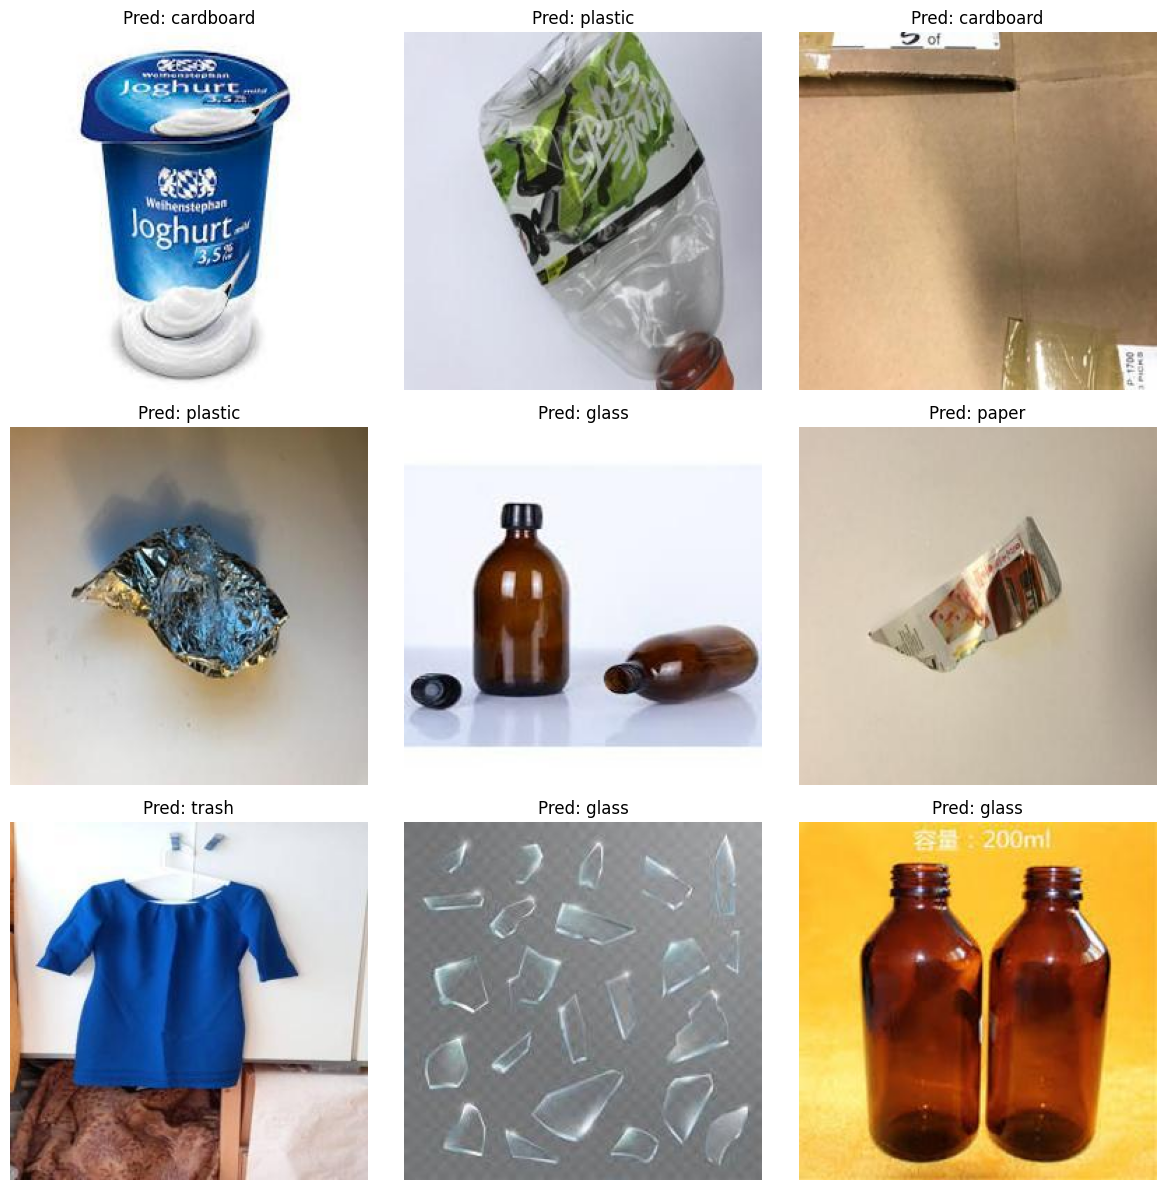

In [15]:
from tensorflow.keras.models import load_model

test_images, test_labels = test_generator_data
best_model = load_model('best_model_gap.keras')

# predictions
y_probs = best_model.predict(test_images)
y_pred = np.argmax(y_probs, axis=1)
y_true = np.argmax(test_labels, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# macro / weighted metrics
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro    = recall_score(y_true, y_pred, average='macro')
f1_macro        = f1_score(y_true, y_pred, average='macro')

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted    = recall_score(y_true, y_pred, average='weighted')
f1_weighted        = f1_score(y_true, y_pred, average='weighted')

print(f"\nPrecision (macro):   {precision_macro:.4f}")
print(f"Recall (macro):      {recall_macro:.4f}")
print(f"F1-score (macro):    {f1_macro:.4f}")
print(f"Precision (weighted): {precision_weighted:.4f}")
print(f"Recall (weighted):    {recall_weighted:.4f}")
print(f"F1-score (weighted):  {f1_weighted:.4f}")

num_samples = 9
idxs = np.random.choice(len(test_images), size=num_samples, replace=False)

plt.figure(figsize=(12,12))

for i, idx in enumerate(idxs):
    img = test_images[idx]
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]

    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {pred_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

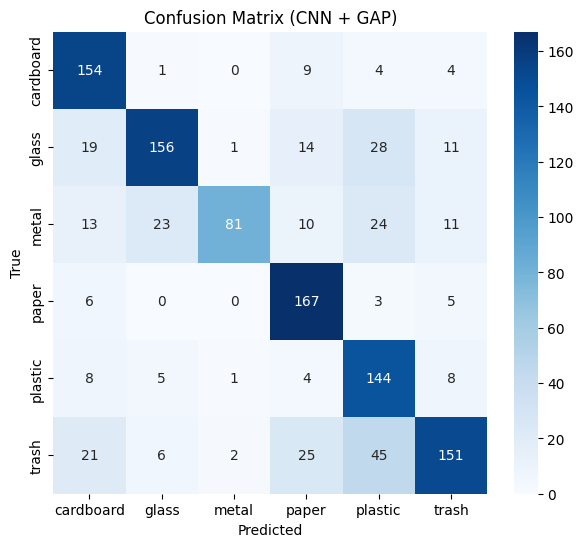

In [11]:
# Confusion Matrix Visualization

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix (CNN + GAP)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


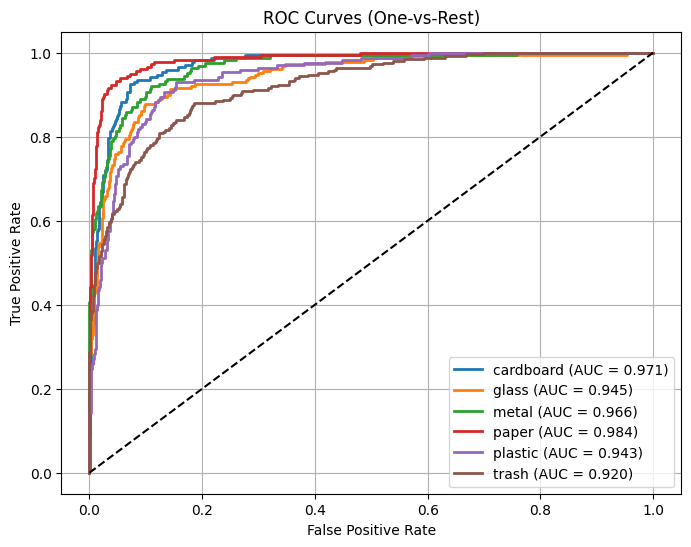

In [12]:
# ROC Curves

from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true == i, y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{class_name} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


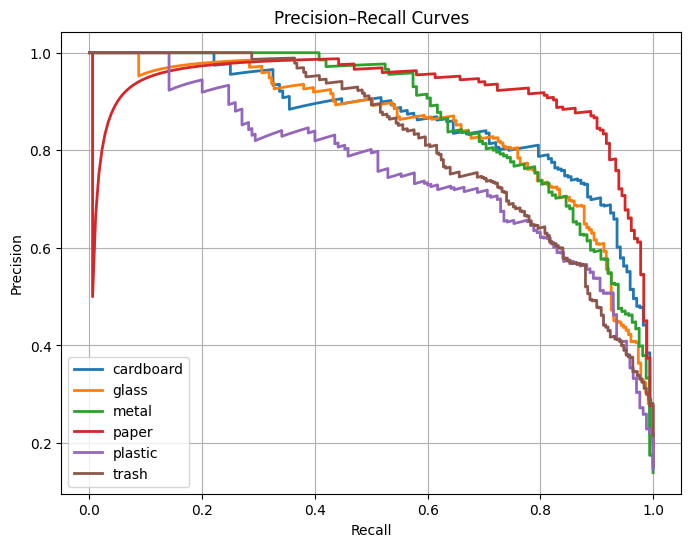

In [13]:
# Precision–Recall Curves

from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(8,6))

for i, class_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_true == i, y_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f"{class_name}")

plt.title("Precision–Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()


## Loss Curve Plots

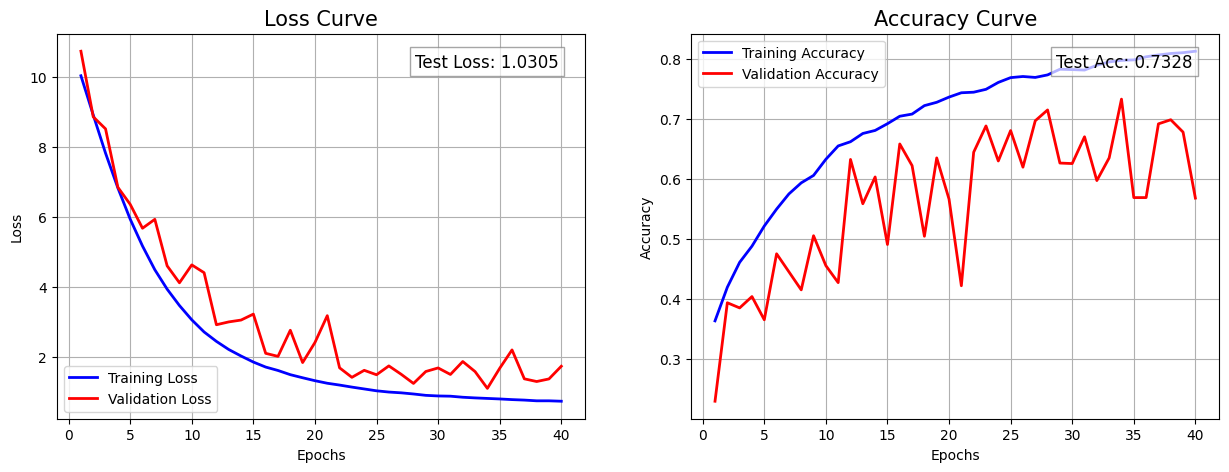

In [14]:
train_loss = history_gap.history['loss']
val_loss   = history_gap.history['val_loss']
train_acc  = history_gap.history['accuracy']
val_acc    = history_gap.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

fig, ax = plt.subplots(1, 2, figsize=(15,5))

# LOSS
ax[0].plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2)
ax[0].plot(epochs, val_loss, 'r-', label='Validation Loss', linewidth=2)
ax[0].set_title("Loss Curve", fontsize=15)
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid(True)

# showing final test loss on chart
ax[0].text(0.95, 0.95, f"Test Loss: {test_loss:.4f}",
           ha='right', va='top', transform=ax[0].transAxes,
           fontsize=12, color='black',
           bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

# ACCURACY
ax[1].plot(epochs, train_acc, 'b-', label='Training Accuracy', linewidth=2)
ax[1].plot(epochs, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
ax[1].set_title("Accuracy Curve", fontsize=15)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].grid(True)


ax[1].text(0.95, 0.95, f"Test Acc: {test_acc:.4f}",
           ha='right', va='top', transform=ax[1].transAxes,
           fontsize=12, color='black',
           bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

plt.show()